This notebook compares various models using the following methology:
1. Firstly a sample of 1/3 of all the NDAs are randomly selected
2. This sample size is then reduced to just the NDA with both additions and related patents, since NDAs without either cannot produce meaningful results.
3. With approximately 300 NDA number, for each NDA:
*   A setid for that NDA with the longest additions history is then selected.
*   All additions for the set-id are grouped together in a list
*   All patents claim related to that set-id are grouped together in a list
*   A random patent with claims for another NDA unrelated to the NDA is selected and all patent claims are grouped in a list
*   The highest similarity scores for each addition to related patent claim is then average together (Related Value).
*   The highest similarity scores for each addition to unrelated patent claim is then averaged together (Noise Value).
*   These average values are collected into a Related list and Unrelated/Noise list so that their distributions can be plotted.

Step 3 is performed repeatedly for multiple models with multiple parameters to test if there is a best model that has a Related distribution furthest away from the noise distribution.


This notebook has been rerunned from scratch with 
model.eval() to ensure deterministic results.  See
https://github.com/huggingface/transformers/issues/695 or https://medium.com/jun-devpblog/pytorch-6-model-train-vs-model-eval-no-grad-hyperparameter-tuning-3812c216a3bd.  As best understood models should be in eval() mode when used for inferences.  Sentence_transformer appears to set the model to eval() in many parts of the code, but not in the `__init__`  for SentenceTransformer.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
zip_path='/content/drive/MyDrive/Colab Notebooks/zip/db2file.zip'
!cp "{zip_path}" .
!cp "/content/drive/MyDrive/Colab Notebooks/requirements.txt" .
!unzip -q db2file.zip
!rm db2file.zip
!rm -r en_core_sci_lg-0.4.0.zip
!cp "/content/drive/MyDrive/Colab Notebooks/zip/en_core_sci_lg-0.4.0.zip" .
!unzip -q en_core_sci_lg-0.4.0.zip
!rm en_core_sci_lg-0.4.0.zip

Mounted at /content/drive
rm: cannot remove 'en_core_sci_lg-0.4.0.zip': No such file or directory


In [2]:
!pip install -r '/content/requirements.txt'

     |████████████████████████████████| 122kB 9.2MB/s 
     |████████████████████████████████| 9.8MB 14.6MB/s 
     |████████████████████████████████| 184kB 44.9MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
     |████████████████████████████████| 6.3MB 38.5MB/s 
     |████████████████████████████████| 1.5MB 46.0MB/s 
     |████████████████████████████████| 13.5MB 55.5MB/s 
     |████████████████████████████████| 15.3MB 33.9MB/s 
     |████████████████████████████████| 9.9MB 39.2MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 296kB 53.0MB/s 
     |████████████████████████████████| 194kB 47.4MB/s 
     |████████████████████████████████| 9.1MB 40.7MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 512kB 48.4MB/s 
     |████████████████████████████████| 727kB 43.4MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
 

In [3]:
import random
import os
random.seed(20)
db2files = "/content/db2file/"
NDA_list=[f for f in os.listdir(db2files)]
random_NDA_list=random.sample(NDA_list, int(len(NDA_list)*.33))

In [4]:
def get_lines_in_file(file_name):
  if os.path.exists(file_name):
    f = open(file_name, "rb")
    return_list = [str(line.decode('unicode_escape')) for line in f if line.decode('unicode_escape').strip()]
    f.close()
    return return_list
  else:
    return []

In [5]:
def flat_list(lst):
  return [item for sublist in lst for item in sublist]

def get_additions(NDA, additions_folder_name):
  """ 
  Return all additions as a list for the set-id with most additions for a NDA 
  excluding the first addition.
  Parameters:
      NDA (string): NDA dir
      additions_folder_name (string): either 'just_additions' or 'additions_with_context'
  """
  if additions_folder_name not in ['just_additions', 'additions_with_context']:
    print(f"Parameter {additions_folder_name} not in ['just_additions', 'additions_with_context']")
    return []
  NDA_dir=db2files+str(NDA)+'/'
  set_id_dirs=[f for f in os.listdir(NDA_dir)]
  try:
    set_id_dirs.remove('patents')
  except ValueError:
    pass
  additions_list=[]
  for set_id_dir in set_id_dirs:
    additions_dir=NDA_dir+set_id_dir+'/'+additions_folder_name+'/'
    if os.path.exists(additions_dir):
      additions_files=sorted([additions_dir+f for f in os.listdir(additions_dir)])[1:]
      additions_list_tmp=flat_list([get_lines_in_file(file) for file in additions_files])
      if len(additions_list_tmp)> len(additions_list):
        additions_list=additions_list_tmp
  return additions_list

def get_patent_claims(NDA, patents_folder_name):
  """Return a list of patents claims for a NDA
  Parameters:
      NDA (string): NDA dir
      patents_folder_name (string): either 'patents' or 'patents_longhand'
  """
  patent_dir=db2files+str(NDA)+'/'+patents_folder_name+'/'
  if os.path.exists(patent_dir):
    patent_files=[patent_dir+f for f in os.listdir(patent_dir)]
    return flat_list([get_lines_in_file(file) for file in patent_files])
  return []
    

In [6]:
# print(get_lines_in_file(db2files+'15923/patents/3438991'))
# print(get_additions(15923, 'just_additions'))
# print(len(get_additions(15923, 'just_additions')))
# print(get_patent_claims(10402, "patents"))
print(len(NDA_list), len(random_NDA_list), random_NDA_list[1])

1606 529 22417


In [7]:

# narrow 1/3 of random data to NDA with patents and NDAs with additions.  If either is missing, we cannot check quality of additions to related patents.
random_NDA_list=[x for x in random_NDA_list if get_patent_claims(x, 'patents') and get_additions(x, 'additions_with_context')]


In [8]:
print(len(random_NDA_list))


295


In [9]:
def calculate_score(random_NDA_list, additions_folder_name, patent_folder_name, scoring_method, optional_scoring_method_field=None, silent=False):
  """
  This method take a scoring_method and returns (bad_average_of_best_scores_list, good_average_of_best_scores_list)
  Parameters:
    random_NDA_list (list): list of NDA numbers
    additions_folder_name (string): either 'patents' or 'patents_longhand'
    patent_folder_name (string): either 'just_additions' or 'additions_with_context'
    scoring_method (function): function that is use to score similarity
  """
  bad_average_of_best_scores_list=[]
  good_average_of_best_scores_list=[]

  for i in range(len(random_NDA_list)):
    if not silent:
      print(f"processing {str(i)} of {str(len(random_NDA_list))}")
    NDA=random_NDA_list[i]

    # choose a bad_NDA (not the current NDA) with patent claims
    bad_NDA = None
    while not bad_NDA:
      new_random_NDA=random.sample(NDA_list, 1)[0]
      if new_random_NDA==NDA:
        continue
      elif get_patent_claims(new_random_NDA, patent_folder_name):
        bad_NDA=new_random_NDA
  
    claims_bad = get_patent_claims(bad_NDA, patent_folder_name)
    claims_good = get_patent_claims(NDA, patent_folder_name)
    additions = get_additions(NDA, additions_folder_name)

    # get average of best similarity scores for patent claims to additions bad_NDA
    bad_average_of_best_scores_list.append(mean(scoring_method(additions, claims_bad, optional_scoring_method_field)))
    # get average of best similarity scores for patent claim for method
    good_average_of_best_scores_list.append(mean(scoring_method(additions, claims_good, optional_scoring_method_field)))

  return bad_average_of_best_scores_list, good_average_of_best_scores_list

def mean(lst):
  return sum(lst)/len(lst)

def std_dev(lst):
  variance = sum([((x - mean(lst)) ** 2) for x in lst]) / len(lst)
  return variance ** 0.5



In [10]:
from sentence_transformers import SentenceTransformer, util

def scoring_method_bert(additions, claims, model):
  """ Returns a list of highest scores for 
  """
  # Compute embedding for both lists
  additions_embeddings = model.encode(
      additions,
      convert_to_tensor=True,
  )
  claims_embeddings = model.encode(
      claims,
      convert_to_tensor=True,
  )
  # Compute cosine-similarity for every additions to every claim
  cosine_scores = util.pytorch_cos_sim(
      additions_embeddings, claims_embeddings
  ).tolist()
  # return the highest similarity score for each section to patent claim
  return [max(x) for x in cosine_scores]

In [11]:
import matplotlib.pyplot as plt

def plot(score_list_set, model, method="Cosine Similarity"):
  plt.subplot(1,2,1)
  plt.hist(score_list_set[0], color="blue", edgecolor="black", bins=int(180/5))
  plt.title(f"Histogram of {method} of Additions to Unrelated Claims (Blue) Versus Related Claims (Green)\n For {model}")
  plt.xlabel('score')
  plt.subplot(1,2,2)
  plt.hist(score_list_set[1], color="green", edgecolor="black", bins=int(180/5))
  plt.xlabel('score')
  plt.show()

def print_mean_std_dev(score_list_set):
  print(f"mean noise: {mean(score_list_set[0])}")
  print(f"std_dev noise: {std_dev(score_list_set[0])}")
  print(f"mean related: {mean(score_list_set[1])}")
  print(f"std_dev related: {std_dev(score_list_set[1])}")

def print_mean_std_dev(score_list_set, plot=plot):
  print(f"mean noise: {mean(score_list_set[0])}")
  print(f"std_dev noise: {std_dev(score_list_set[0])}")
  print(f"mean related: {mean(score_list_set[1])}")
  print(f"std_dev related: {std_dev(score_list_set[1])}")

import scipy.stats

def print_z_score(score_list_set):
  """ 
  Print Z score which is number of standard deviations (wherein distribution is 
  centered at 0) of the means of the additions to related patent is to the mean 
  of additions to unrelated patent.
  z=(x-u)/s; where x is the mean of additions to related patents, and u is means 
  of additions to unrelated patents, and x is standard deviation of additions to 
  unrelated patents.
  p(-z) is the probability that is it better than noise
  """
  z_score=(mean(score_list_set[1])-mean(score_list_set[0]))/std_dev(score_list_set[0])
  print(f"z_score: {z_score}")
  print(f"p(-z): {scipy.stats.norm.sf(z_score*-1)}")

def plot_print(score_list_set, model, method="Cosine Similarity", plot_=plot):
  plot_(score_list_set, model, method="Cosine Similarity")
  print_mean_std_dev(score_list_set)
  print_z_score(score_list_set)

_device=None

In [12]:
# distilroberta_with_context is a set of (bad average of best similarity scores list, good average of best similarity scores list)
_device = None
model_distilroberta = SentenceTransformer("stsb-distilroberta-base-v2", device=_device)
model_distilroberta.eval()
model_distilroberta.zero_grad()
model_distilroberta.max_seq_length=512
distilroberta_additions_with_context_patents=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_bert, model_distilroberta, silent=True)

  0%|          | 0.00/305M [00:00<?, ?B/s]

In [13]:
model_distilroberta.zero_grad()
distilroberta_just_additions_patents=calculate_score(random_NDA_list, "just_additions", "patents", scoring_method_bert, model_distilroberta, silent=True)

In [14]:
model_distilroberta.zero_grad()
distilroberta_additions_with_context_patents_longhand=calculate_score(random_NDA_list, "additions_with_context", "patents_longhand", scoring_method_bert, model_distilroberta, silent=True)

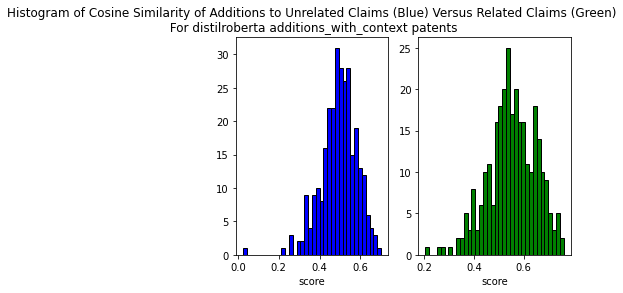

mean noise: 0.49429224932004184
std_dev noise: 0.08914535609158014
mean related: 0.5527198500920639
std_dev related: 0.09542776364072823
z_score: 0.6554194557481904
p(-z): 0.743901135772199


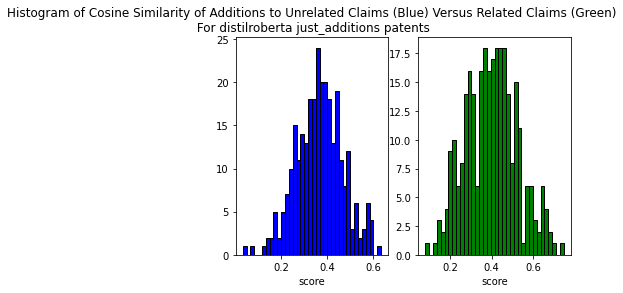

mean noise: 0.36533162833997584
std_dev noise: 0.1016254501947882
mean related: 0.39701289436555565
std_dev related: 0.12510706923827297
z_score: 0.311745394139514
p(-z): 0.6223829868289659


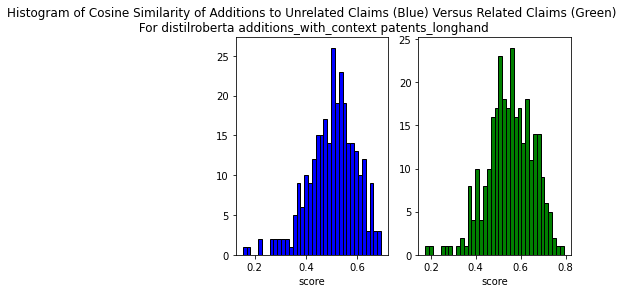

mean noise: 0.5011662935146586
std_dev noise: 0.09381052112162212
mean related: 0.5511816819268379
std_dev related: 0.1032884523070586
z_score: 0.5331532946857432
p(-z): 0.7030362653302791


In [15]:
plot_print(distilroberta_additions_with_context_patents, "distilroberta additions_with_context patents")
plot_print(distilroberta_just_additions_patents, "distilroberta just_additions patents")
plot_print(distilroberta_additions_with_context_patents_longhand, "distilroberta additions_with_context patents_longhand")

In [16]:
model_scibert_uncased = SentenceTransformer("allenai/scibert_scivocab_uncased", device=_device)
model_scibert_uncased.max_seq_length=512
model_scibert_uncased.zero_grad()
model_scibert_uncased.eval()
scibert_uncased=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_bert, model_scibert_uncased, silent=True)

Exception when trying to download http://sbert.net/models/allenai/scibert_scivocab_uncased.zip. Response 404
SentenceTransformer-Model http://sbert.net/models/allenai/scibert_scivocab_uncased.zip not found. Try to create it from scratch
Try to create Transformer Model allenai/scibert_scivocab_uncased with mean pooling


Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

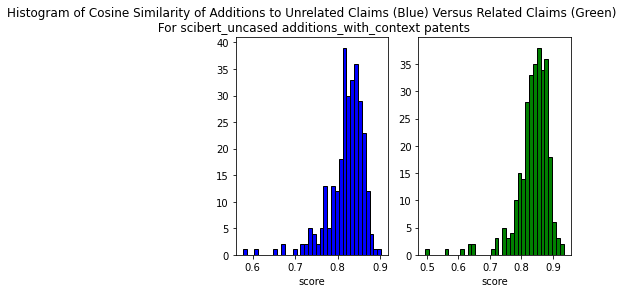

mean noise: 0.8199905620397728
std_dev noise: 0.04251488509572398
mean related: 0.8364760396810583
std_dev related: 0.053060990019790526
z_score: 0.3877577842246963
p(-z): 0.6509023554100891


In [17]:
plot_print(scibert_uncased, "scibert_uncased additions_with_context patents")

Exception when trying to download http://sbert.net/models/allenai/longformer-base-4096.zip. Response 404
SentenceTransformer-Model http://sbert.net/models/allenai/longformer-base-4096.zip not found. Try to create it from scratch
Try to create Transformer Model allenai/longformer-base-4096 with mean pooling


Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/597M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

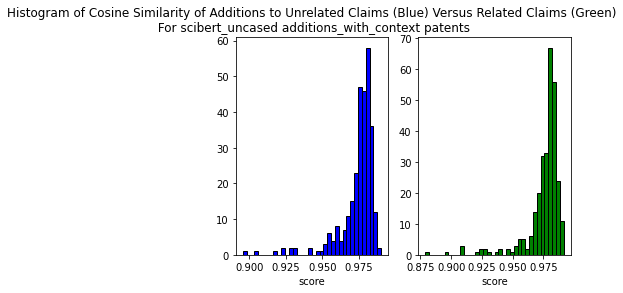

mean noise: 0.9741629018030186
std_dev noise: 0.012779381267690786
mean related: 0.9749349267657725
std_dev related: 0.015104129271941429
z_score: 0.060411763807832114
p(-z): 0.5240861551963808


In [18]:
model_longformer = SentenceTransformer("allenai/longformer-base-4096", device=_device)
# Will limit size since CUDA runs out of memory
model_longformer.max_seq_length=1024
model_longformer.eval()
model_longformer.zero_grad()
longformer=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_bert, model_longformer, silent=True)
model_longformer.zero_grad()
plot_print(longformer, "scibert_uncased additions_with_context patents")

Exception when trying to download http://sbert.net/models/dmis-lab/biobert-v1.1.zip. Response 404
SentenceTransformer-Model http://sbert.net/models/dmis-lab/biobert-v1.1.zip not found. Try to create it from scratch
Try to create Transformer Model dmis-lab/biobert-v1.1 with mean pooling


Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

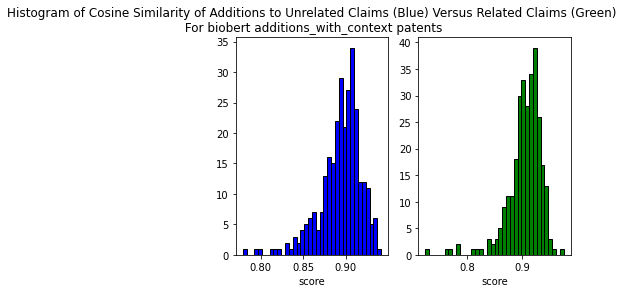

mean noise: 0.8937992962006303
std_dev noise: 0.024884316916459617
mean related: 0.9041456578325194
std_dev related: 0.030564762687182712
z_score: 0.41577840640044356
p(-z): 0.661213919340748


In [19]:
model_biobert = SentenceTransformer("dmis-lab/biobert-v1.1", device=_device)
model_biobert.zero_grad()
model_biobert.eval()
# Will limit size since CUDA runs out of memory
model_longformer.max_seq_length=512
biobert=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_bert, model_biobert, silent=True)
model_biobert.zero_grad()
plot_print(biobert, "biobert additions_with_context patents")

  0%|          | 0.00/404M [00:00<?, ?B/s]

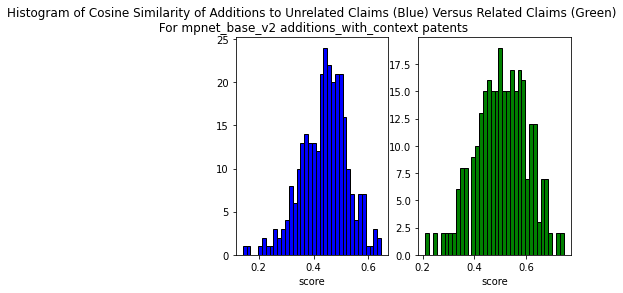

mean noise: 0.4394819725480835
std_dev noise: 0.08450590528523012
mean related: 0.5071892047193506
std_dev related: 0.1004630006104196
z_score: 0.8012130269800314
p(-z): 0.7884958345501627


In [20]:
model_mpnet_base_v2 = SentenceTransformer("stsb-mpnet-base-v2", device=_device)
model_mpnet_base_v2.zero_grad()
model_mpnet_base_v2.eval()
# Will limit size since CUDA runs out of memory
model_mpnet_base_v2.max_seq_length=512
mpnet_base_v2=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_bert, model_mpnet_base_v2, silent=True)
model_mpnet_base_v2.zero_grad()
plot_print(mpnet_base_v2, "mpnet_base_v2 additions_with_context patents")

  0%|          | 0.00/460M [00:00<?, ?B/s]

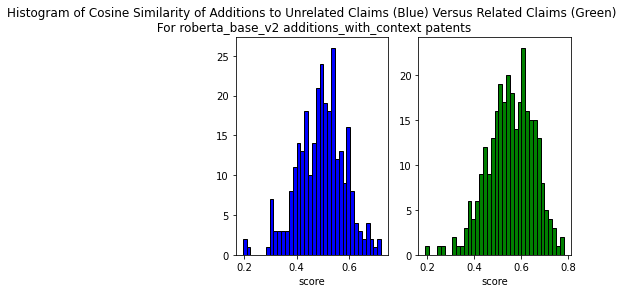

mean noise: 0.49227264334059345
std_dev noise: 0.08965576755560903
mean related: 0.5540247372735316
std_dev related: 0.09759305733269955
z_score: 0.6887687832758379
p(-z): 0.7545156084196327


In [21]:
model_roberta_base_v2 = SentenceTransformer("stsb-roberta-base-v2", device=_device)
model_roberta_base_v2.zero_grad()
model_roberta_base_v2.eval()
# Will limit size since CUDA runs out of memory
model_roberta_base_v2.max_seq_length=512
roberta_base_v2=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_bert, model_roberta_base_v2, silent=True)
model_roberta_base_v2.zero_grad()
plot_print(roberta_base_v2, "roberta_base_v2 additions_with_context patents")

In [22]:
import spacy
gpu = spacy.prefer_gpu()
print('GPU:', gpu)
!pip install -U spacy[cuda101]
_N_PROCESS = 1
_en_core_sci_lg_nlp = spacy.load("/content/en_core_sci_lg-0.4.0/en_core_sci_lg/en_core_sci_lg-0.4.0")
# set number of processes for nlp.pipe for spaCy
# _N_PROCESS = 3

GPU: True
Requirement already up-to-date: spacy[cuda101] in /usr/local/lib/python3.7/dist-packages (3.0.6)


In [23]:
def preprocess_with_spacy_nlp(text_list, steps, nlp=_en_core_sci_lg_nlp):
    """
    This method can remove punctuation,
    Parameters:
        text_list (list): list of strings
        steps (list): one of ["punct", "lemma", "stopwords"]
    """
    # make a copy of text_lis
    return_list = text_list
    if any(item in ["punct", "lemma", "stopwords"] for item in steps):
        # 'lemmatizer' required 'tagger' and 'attribute_ruler'
        nlp_list = list(
            nlp.pipe(
                return_list,
                disable=["tok2vec", "ner"],
                n_process=_N_PROCESS,
            )
        )
        return_list = [
            " ".join(
                [
                    token.lemma_ if "lemma" in steps else token.text
                    for token in doc
                    if (
                        (
                            ("punct" in steps and not token.is_punct)
                            or "punct" not in steps
                        )
                        and (
                            ("stopwords" in steps and not token.is_stop)
                            or "stopwords" not in steps
                        )
                    )
                ]
            )
            for doc in nlp_list
        ]
    return return_list


def similarity_matrix(embed_A_list, embed_B_list):
    """
    This method returns a matrix such as:
        [[X, X, X],
        [X, X, X]]
    wherein each row represents the similarity measurement between an embedding
    from embed_A_list to each of the embeddings in embed_B_list.

    Parameters:
        embed_A_list (list): list of NLP object generated by spaCy
        embed_B_list (list): list of NLP object generated by spaCy to be
                             compared to embed_A
    """
    matrix = [[0] * len(embed_B_list) for y in range(len(embed_A_list))]
    for i in range(len(embed_A_list)):
        for j in range(len(embed_B_list)):
            matrix[i][j] = embed_A_list[i].similarity(embed_B_list[j])
    return matrix


def scoring_method_spacy(additions, claims, nlp=_en_core_sci_lg_nlp):
  """ Scores with spaCy
  """
  additions=preprocess_with_spacy_nlp(additions, ["punct", "lemma", "stopwords"], nlp)
  claims=preprocess_with_spacy_nlp(claims, ["punct", "lemma", "stopwords"], nlp)
  # Compute embedding for both lists
  # tokenization only requires tok2vec
  disabled_list = ["tagger", "attribute_ruler", "lemmatizer", "parser", "ner"]
  additions_embeddings = list(
      nlp.pipe(
          additions, disable=disabled_list, n_process=_N_PROCESS
      )
  )
  claims_embeddings = list(
      nlp.pipe(
          claims, disable=disabled_list, n_process=_N_PROCESS
      )
  )
  # Compute cosine-similarity for every additions to every claim
  cosine_scores = similarity_matrix(additions_embeddings, claims_embeddings)
  # return the highest similarity score for each section to patent claim
  return [max(x) for x in cosine_scores]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.


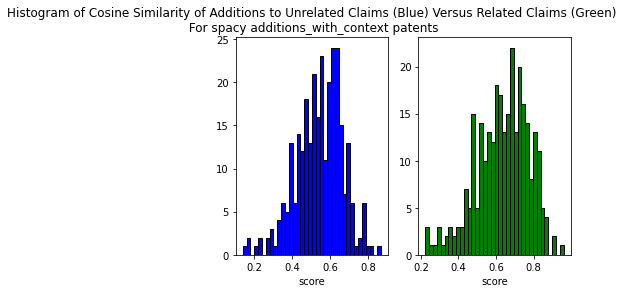

mean noise: 0.5410768461186833
std_dev noise: 0.1218373491691527
mean related: 0.6339932107695609
std_dev related: 0.13988376253719897
z_score: 0.7626262823715683
p(-z): 0.777156847169474


In [24]:
spacy_sci=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_spacy, _en_core_sci_lg_nlp, silent=True)
plot_print(spacy_sci, "spacy additions_with_context patents")

Note:  There was a crash due to here due to spacy' en_core_web_trf having issues with GPU.  Resetting seed to continue run of file.

In [33]:
random.seed(20)
random_NDA_list=random.sample(NDA_list, int(len(NDA_list)*.33))
# narrow 1/3 of random data to NDA with patents and NDAs with additions.  If either is missing, we cannot check quality of additions to related patents.
random_NDA_list=[x for x in random_NDA_list if get_patent_claims(x, 'patents') and get_additions(x, 'additions_with_context')]
print(len(random_NDA_list))

295


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
vectorizer = TfidfVectorizer()

def similarity_matrix_tfidf(embed_A, embed_B):
    """
    This method returns a matrix such as:
        [[X, X, X],
        [X, X, X]]
    wherein each row represents the similarity measurement between an embedding
    from embed_A to each of the embeddings in embed_B.

    Parameters:
        embed_A (ndarray): ndarray object generated by scikit-learn of shape
                           (n_samples, n_features)
        embed_B (ndarray): ndarray object generated by scikit-learn of shape
                           (n_samples, n_features) to be compared to embed_A
    """
    matrix = [[0] * embed_B.shape[0] for y in range(embed_A.shape[0])]
    for i in range(embed_A.shape[0]):
        for j in range(embed_B.shape[0]):
            matrix[i][j] = cosine_similarity(embed_A[i], embed_B[j]).item()
    return matrix

def scoring_method_tfidf(additions, claims, empty):
  """ Scores with tfidf
  """
  additions=preprocess_with_spacy_nlp(additions, ["punct", "lemma", "stopwords"])
  claims=preprocess_with_spacy_nlp(claims, ["punct", "lemma", "stopwords"])

  all_embeddings = vectorizer.fit_transform(additions + claims)
  additions_embeddings = all_embeddings[: len(additions)]
  claims_embeddings = all_embeddings[len(additions) :]

  # Compute cosine-similarity for every additions to every claim
  cosine_scores = similarity_matrix_tfidf(additions_embeddings, claims_embeddings)

  # return the highest similarity score for each section to patent claim
  return [max(x) for x in cosine_scores]


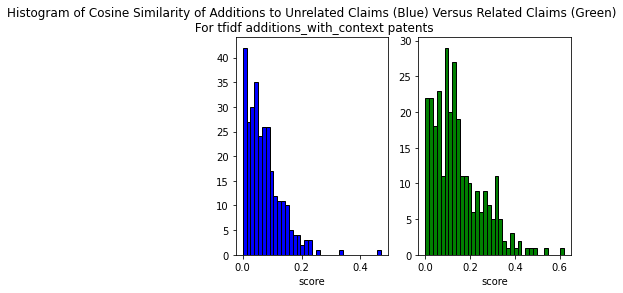

mean noise: 0.07183518659353128
std_dev noise: 0.06059509921121825
mean related: 0.1444162698265769
std_dev related: 0.11068076907316785
z_score: 1.197804511880531
p(-z): 0.8845034348456072


In [35]:
tfidf=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_tfidf, silent=True)
plot_print(tfidf, "tfidf additions_with_context patents")

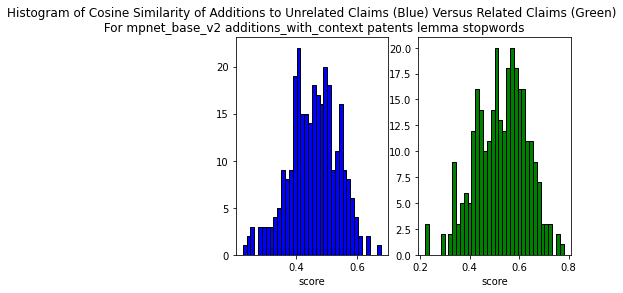

mean noise: 0.4543968163156192
std_dev noise: 0.08023551681697666
mean related: 0.5264618938092277
std_dev related: 0.10278864911122886
z_score: 0.8981692940047294
p(-z): 0.8154523495416832


In [36]:
def scoring_method_bert_with_preprocessing(additions, claims, model):
  """ Returns drops list of max cosines scores for each addition to claim, but drops stops word, lemmatize
  """
  additions=preprocess_with_spacy_nlp(additions, ["lemma", "stopwords"])
  claims=preprocess_with_spacy_nlp(claims, ["lemma", "stopwords"])
  # Compute embedding for both lists
  additions_embeddings = model.encode(
      additions,
      convert_to_tensor=True,
  )
  claims_embeddings = model.encode(
      claims,
      convert_to_tensor=True,
  )
  # Compute cosine-similarity for every additions to every claim
  cosine_scores = util.pytorch_cos_sim(
      additions_embeddings, claims_embeddings
  ).tolist()
  # return the highest similarity score for each section to patent claim
  return [max(x) for x in cosine_scores]
model_mpnet_base_v2 = SentenceTransformer("stsb-mpnet-base-v2", device=_device)
model_mpnet_base_v2.eval()
model_mpnet_base_v2.zero_grad()
# Will limit size since CUDA runs out of memory
model_mpnet_base_v2.max_seq_length=512
mpnet_base_v2_lemma_stop=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_bert_with_preprocessing, model_mpnet_base_v2, silent=True)
model_mpnet_base_v2.zero_grad()
plot_print(mpnet_base_v2_lemma_stop, "mpnet_base_v2 additions_with_context patents lemma stopwords")

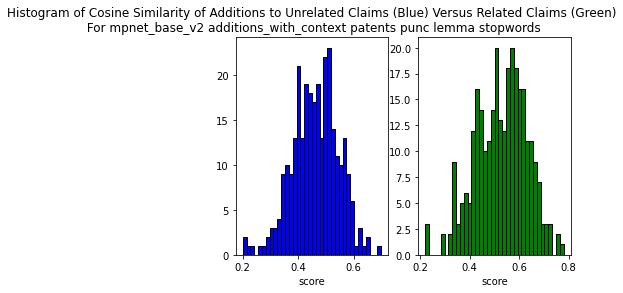

mean noise: 0.460795348052535
std_dev noise: 0.0826688762446277
mean related: 0.5264618938092277
std_dev related: 0.10278864911122886
z_score: 0.7943321445712778
p(-z): 0.7864989522765493


In [37]:
def scoring_method_bert_with_preprocessing(additions, claims, model):
  """ Returns drops list of max cosines scores for each addition to claim, but drops stops word, lemmatize
  """
  additions=preprocess_with_spacy_nlp(additions, ["punc", "lemma", "stopwords"])
  claims=preprocess_with_spacy_nlp(claims, ["punc", "lemma", "stopwords"])
  # Compute embedding for both lists
  additions_embeddings = model.encode(
      additions,
      convert_to_tensor=True,
  )
  claims_embeddings = model.encode(
      claims,
      convert_to_tensor=True,
  )
  # Compute cosine-similarity for every additions to every claim
  cosine_scores = util.pytorch_cos_sim(
      additions_embeddings, claims_embeddings
  ).tolist()
  # return the highest similarity score for each section to patent claim
  return [max(x) for x in cosine_scores]
model_mpnet_base_v2 = SentenceTransformer("stsb-mpnet-base-v2", device=_device)
model_mpnet_base_v2.eval()
model_mpnet_base_v2.zero_grad()
# Will limit size since CUDA runs out of memory
model_mpnet_base_v2.max_seq_length=512
mpnet_base_v2_punc_lemma_stop=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_bert_with_preprocessing, model_mpnet_base_v2, silent=True)
model_mpnet_base_v2.zero_grad()
plot_print(mpnet_base_v2_punc_lemma_stop, "mpnet_base_v2 additions_with_context patents punc lemma stopwords")

In [38]:
def plot2(score_list_set, model, method="Cosine Similarity"):
  fig,ax=plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
  fig.suptitle(f"Histogram of {method} of Additions to Unrelated Claims (Blue) Versus Related Claims (Green)\n For {model}")
  ax[0].hist(score_list_set[0], color="blue", edgecolor="black", bins=int(180/5))
  ax[1].hist(score_list_set[1], color="green", edgecolor="black", bins=int(180/5))
  ax[1].set_xlabel('score')
  display(fig)
  plt.close()



The following presents the historgram plots shown above in a more viewer friendly manner.

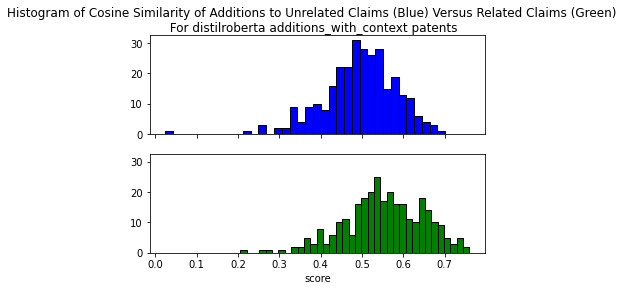

mean noise: 0.49429224932004184
std_dev noise: 0.08914535609158014
mean related: 0.5527198500920639
std_dev related: 0.09542776364072823
z_score: 0.6554194557481904
p(-z): 0.743901135772199


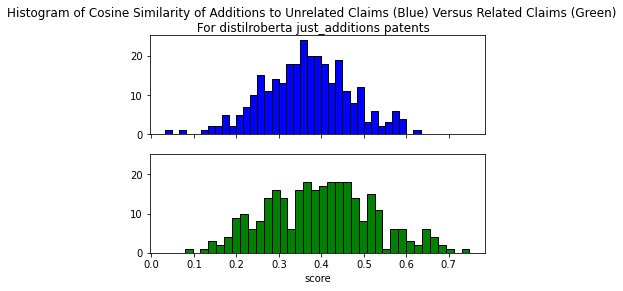

mean noise: 0.36533162833997584
std_dev noise: 0.1016254501947882
mean related: 0.39701289436555565
std_dev related: 0.12510706923827297
z_score: 0.311745394139514
p(-z): 0.6223829868289659


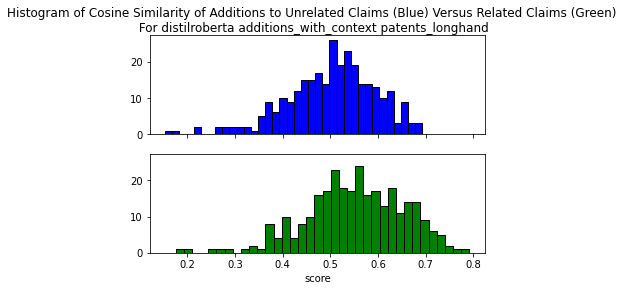

mean noise: 0.5011662935146586
std_dev noise: 0.09381052112162212
mean related: 0.5511816819268379
std_dev related: 0.1032884523070586
z_score: 0.5331532946857432
p(-z): 0.7030362653302791


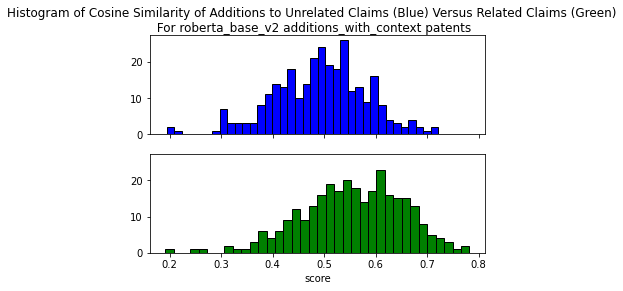

mean noise: 0.49227264334059345
std_dev noise: 0.08965576755560903
mean related: 0.5540247372735316
std_dev related: 0.09759305733269955
z_score: 0.6887687832758379
p(-z): 0.7545156084196327


In [39]:
plot_print(distilroberta_additions_with_context_patents, "distilroberta additions_with_context patents", plot_=plot2)
plot_print(distilroberta_just_additions_patents, "distilroberta just_additions patents", plot_=plot2)
plot_print(distilroberta_additions_with_context_patents_longhand, "distilroberta additions_with_context patents_longhand", plot_=plot2)
plot_print(roberta_base_v2, "roberta_base_v2 additions_with_context patents", plot_=plot2)

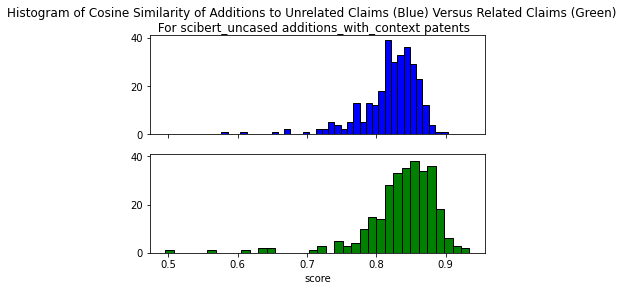

mean noise: 0.8199905620397728
std_dev noise: 0.04251488509572398
mean related: 0.8364760396810583
std_dev related: 0.053060990019790526
z_score: 0.3877577842246963
p(-z): 0.6509023554100891


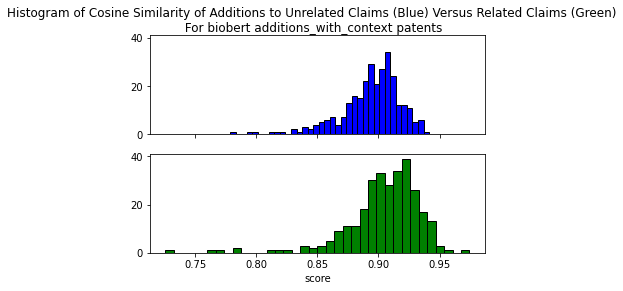

mean noise: 0.8937992962006303
std_dev noise: 0.024884316916459617
mean related: 0.9041456578325194
std_dev related: 0.030564762687182712
z_score: 0.41577840640044356
p(-z): 0.661213919340748


In [40]:
plot_print(scibert_uncased, "scibert_uncased additions_with_context patents", plot_=plot2)
plot_print(biobert, "biobert additions_with_context patents", plot_=plot2)

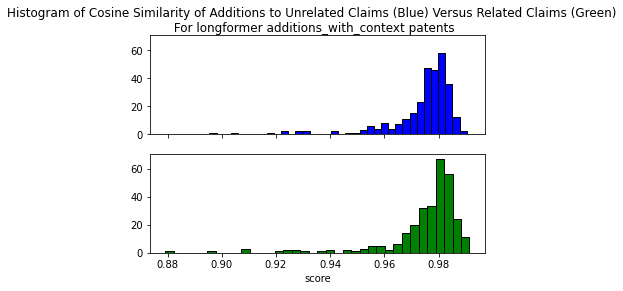

mean noise: 0.9741629018030186
std_dev noise: 0.012779381267690786
mean related: 0.9749349267657725
std_dev related: 0.015104129271941429
z_score: 0.060411763807832114
p(-z): 0.5240861551963808


In [41]:
plot_print(longformer, "longformer additions_with_context patents", plot_=plot2)

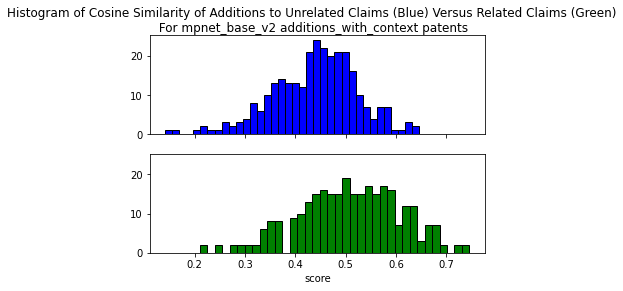

mean noise: 0.4394819725480835
std_dev noise: 0.08450590528523012
mean related: 0.5071892047193506
std_dev related: 0.1004630006104196
z_score: 0.8012130269800314
p(-z): 0.7884958345501627


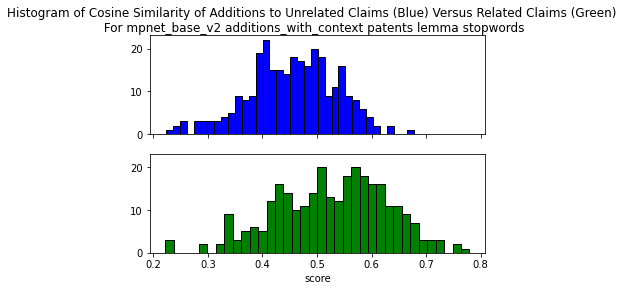

mean noise: 0.4543968163156192
std_dev noise: 0.08023551681697666
mean related: 0.5264618938092277
std_dev related: 0.10278864911122886
z_score: 0.8981692940047294
p(-z): 0.8154523495416832


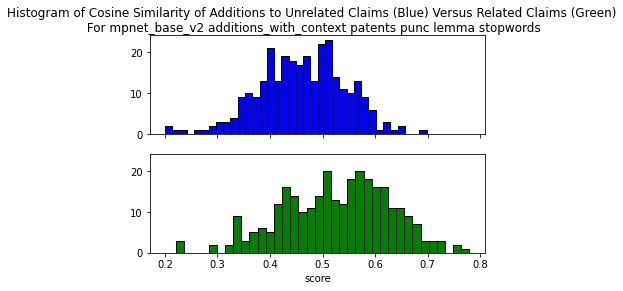

mean noise: 0.460795348052535
std_dev noise: 0.0826688762446277
mean related: 0.5264618938092277
std_dev related: 0.10278864911122886
z_score: 0.7943321445712778
p(-z): 0.7864989522765493


In [42]:
plot_print(mpnet_base_v2, "mpnet_base_v2 additions_with_context patents", plot_=plot2)
plot_print(mpnet_base_v2_lemma_stop, "mpnet_base_v2 additions_with_context patents lemma stopwords", plot_=plot2)
plot_print(mpnet_base_v2_punc_lemma_stop, "mpnet_base_v2 additions_with_context patents punc lemma stopwords", plot_=plot2)

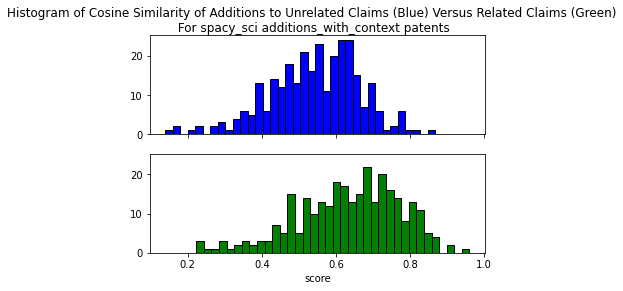

mean noise: 0.5410768461186833
std_dev noise: 0.1218373491691527
mean related: 0.6339932107695609
std_dev related: 0.13988376253719897
z_score: 0.7626262823715683
p(-z): 0.777156847169474


In [45]:
plot_print(spacy_sci, "spacy_sci additions_with_context patents", plot_=plot2)

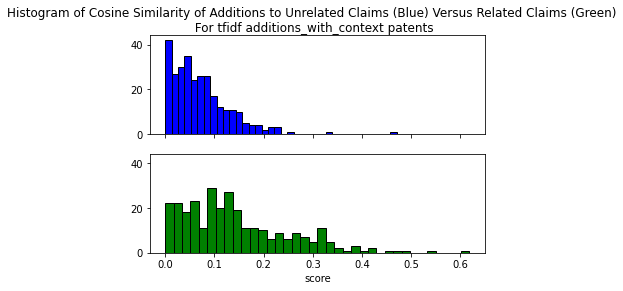

mean noise: 0.07183518659353128
std_dev noise: 0.06059509921121825
mean related: 0.1444162698265769
std_dev related: 0.11068076907316785
z_score: 1.197804511880531
p(-z): 0.8845034348456072


In [46]:
plot_print(tfidf, "tfidf additions_with_context patents", plot_=plot2)

The following reruns multi_mpnet_base_v2, which has among the highest z-score from the noise distribution, 4 more times with a different sample of random NDAs to confirm general performance of mpnet_base_v2.

mpnet_base_v2 is a prime candidate for the NLP engine, since its has a relatively high z-score from the noise model, but also since it works well without lots of preprocessing steps.  Furthermore the variance of mpnet_base_v2 distribution is smaller.  A smaller variance indicates that the mpnet_base_v2 is more consistent.  ScispaCy also has a high z-score, but it's distribution variance is higher too, which is less desirable.

***NDA_Size:  295


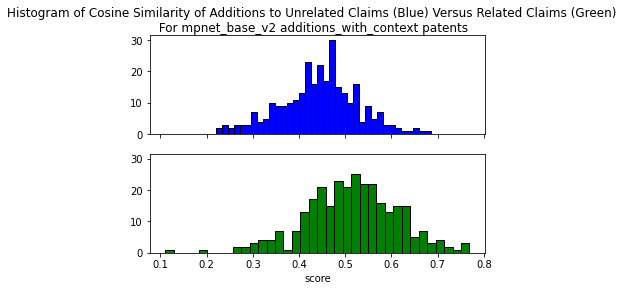

mean noise: 0.4431873974794944
std_dev noise: 0.08552639934456163
mean related: 0.513381457580622
std_dev related: 0.10005723888801957
z_score: 0.8207297470613211
p(-z): 0.7940998886189631
***NDA_Size:  295


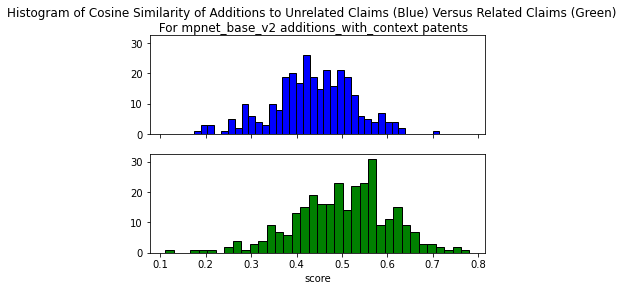

mean noise: 0.4354695410997088
std_dev noise: 0.09067967695881683
mean related: 0.5019356837314046
std_dev related: 0.10727972966568003
z_score: 0.7329772762852049
p(-z): 0.768213855478854
***NDA_Size:  295


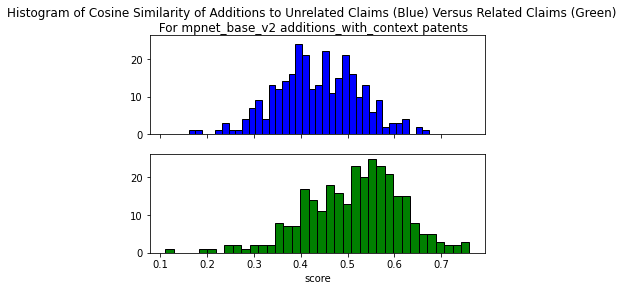

mean noise: 0.43612821309920635
std_dev noise: 0.0888772012551482
mean related: 0.5139553849792882
std_dev related: 0.10412893950036337
z_score: 0.8756708219991759
p(-z): 0.8093954940610997
***NDA_Size:  295


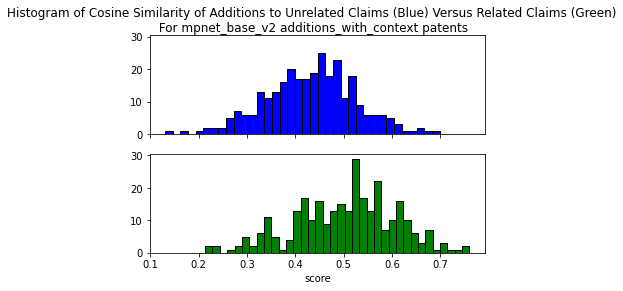

mean noise: 0.4315910989872214
std_dev noise: 0.09332508415909309
mean related: 0.5036275690466826
std_dev related: 0.10497826393864124
z_score: 0.7718875445818961
p(-z): 0.7799094825098116


In [48]:
model_mpnet_base_v2 = SentenceTransformer("stsb-mpnet-base-v2", device=_device)
model_mpnet_base_v2.eval()

# set new seed
random.seed(30)

for i in range(4):
  # grab a few extra NDA to ensure that there will always be 295 NDAs
  random_NDA_list=random.sample(NDA_list, int(len(NDA_list)*.40))
  # narrow 1/3 of random data to NDA with patents and NDAs with additions.  If either is missing, we cannot check quality of additions to related patents.
  random_NDA_list=[x for x in random_NDA_list if get_patent_claims(x, 'patents') and get_additions(x, 'additions_with_context')]
  # truncate down to 295 NDA to match sample size from above
  random_NDA_list=random_NDA_list[:295]
  print("***NDA_Size: ", len(random_NDA_list))
  model_mpnet_base_v2.zero_grad()
  # Will limit size since CUDA runs out of memory
  model_mpnet_base_v2.max_seq_length=512
  multi_mpnet_base_v2=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_bert, model_mpnet_base_v2, silent=True)
  plot_print(multi_mpnet_base_v2, "mpnet_base_v2 additions_with_context patents", plot_=plot2)


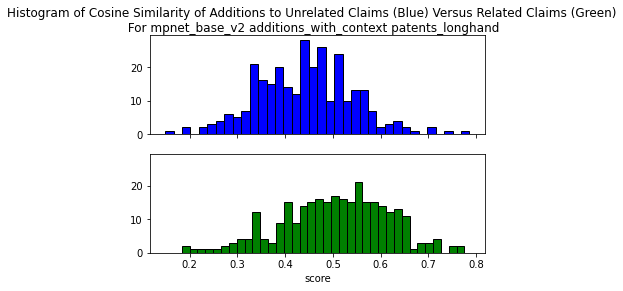

mean noise: 0.44185767490864586
std_dev noise: 0.09998847521011013
mean related: 0.5051426554419208
std_dev related: 0.11043737986518015
z_score: 0.6329227483496622
p(-z): 0.7366079541599596


In [50]:
model_mpnet_base_v2.zero_grad()
model_mpnet_base_v2.eval()
# Will limit size since CUDA runs out of memory
model_mpnet_base_v2.max_seq_length=512
mpnet_base_v2_longhand=calculate_score(random_NDA_list, "additions_with_context", "patents_longhand", scoring_method_bert, model_mpnet_base_v2, silent=True)
model_mpnet_base_v2.zero_grad()
plot_print(mpnet_base_v2_longhand, "mpnet_base_v2 additions_with_context patents_longhand", plot_=plot2)